In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

LG = pklload("./database/00_LocalGroup.pickle")
print(LG.keys())
print(LG[2].keys())

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


In [3]:
BGGs = None
for key in LG.keys():
    BGG = LG[key]['BGG']
    BGGs = BGG if(BGGs is None) else np.hstack((BGGs, BGG))
assert len(BGGs) == len(np.unique(BGGs['halo_id']))

subs = None
hosts = None
for key in LG.keys():
    sub = LG[key]['subs']
    host = np.full(len(sub), key, dtype=int)
    subs = sub if(subs is None) else np.hstack((subs, sub))
    hosts = host if(hosts is None) else np.hstack((hosts, host))


mainhalos = subs['id'][ isin(subs['id'], BGGs['halo_id']) ]
for mainhalo in mainhalos:
    where = np.where(BGGs['halo_id'] == mainhalo)[0][0]
    print(f"Galaxy[{BGGs[where]['id']}] <-> Halo[{mainhalo}]")
    for sub,host in zip(subs,hosts):
        if(sub['id'] == mainhalo):
            print(f"\t! Found in Galaxy[{host}]")

        

Galaxy[92] <-> Halo[19515]
	! Found in Galaxy[4]
Galaxy[10] <-> Halo[5461]
	! Found in Galaxy[7]
Galaxy[11] <-> Halo[24588]
	! Found in Galaxy[25]
Galaxy[9] <-> Halo[3321]
	! Found in Galaxy[29]
Galaxy[2] <-> Halo[1417]
	! Found in Galaxy[35]
	! Found in Galaxy[52]
	! Found in Galaxy[92]
Galaxy[108] <-> Halo[1356]
	! Found in Galaxy[40]
Galaxy[2] <-> Halo[1417]
	! Found in Galaxy[35]
	! Found in Galaxy[52]
	! Found in Galaxy[92]
Galaxy[36] <-> Halo[5540]
	! Found in Galaxy[84]
Galaxy[4] <-> Halo[573]
	! Found in Galaxy[92]
Galaxy[2] <-> Halo[1417]
	! Found in Galaxy[35]
	! Found in Galaxy[52]
	! Found in Galaxy[92]
Galaxy[40] <-> Halo[1340]
	! Found in Galaxy[108]


In [4]:
BGGs = None
for key in LG.keys():
    BGG = LG[key]['BGG']
    BGGs = BGG if(BGGs is None) else np.hstack((BGGs, BGG))
assert len(BGGs) == len(np.unique(BGGs['halo_id']))

subs = None
hosts = None
allsubs = {}
for key in LG.keys():
    sub = LG[key]['subs']
    host = np.full(len(sub), key, dtype=int)
    subs = sub if(subs is None) else np.hstack((subs, sub))
    hosts = host if(hosts is None) else np.hstack((hosts, host))
    allsubs[key] = np.append( LG[key]['subs']['id'], LG[key]['BGG']['halo_id'] )


for key in LG.keys():
    mysubs = allsubs[key]
    for jkey in LG.keys():
        if(key == jkey): continue
        jsubs = allsubs[jkey]
        for mysub in mysubs:
            if(mysub in jsubs):
                print(f"Galaxy[{key}] <-> Galaxy[{jkey}]")
                print(f"\t! {mysub} Found !")

Galaxy[2] <-> Galaxy[35]
	! 1417 Found !
Galaxy[2] <-> Galaxy[52]
	! 1417 Found !
Galaxy[2] <-> Galaxy[92]
	! 1417 Found !
Galaxy[4] <-> Galaxy[92]
	! 19515 Found !
Galaxy[4] <-> Galaxy[92]
	! 573 Found !
Galaxy[7] <-> Galaxy[10]
	! 5461 Found !
Galaxy[9] <-> Galaxy[29]
	! 3321 Found !
Galaxy[10] <-> Galaxy[7]
	! 5461 Found !
Galaxy[25] <-> Galaxy[11]
	! 24588 Found !
Galaxy[29] <-> Galaxy[9]
	! 3321 Found !
Galaxy[35] <-> Galaxy[2]
	! 1417 Found !
Galaxy[35] <-> Galaxy[52]
	! 1417 Found !
Galaxy[35] <-> Galaxy[92]
	! 1417 Found !
Galaxy[36] <-> Galaxy[84]
	! 5540 Found !
Galaxy[40] <-> Galaxy[108]
	! 1356 Found !
Galaxy[40] <-> Galaxy[108]
	! 1340 Found !
Galaxy[52] <-> Galaxy[2]
	! 1417 Found !
Galaxy[52] <-> Galaxy[35]
	! 1417 Found !
Galaxy[52] <-> Galaxy[92]
	! 1417 Found !
Galaxy[84] <-> Galaxy[36]
	! 5540 Found !
Galaxy[92] <-> Galaxy[2]
	! 1417 Found !
Galaxy[92] <-> Galaxy[4]
	! 573 Found !
Galaxy[92] <-> Galaxy[4]
	! 19515 Found !
Galaxy[92] <-> Galaxy[35]
	! 1417 Found !
Gal

[7] H:24178 (dodgerblue)


[10] H:5461 (orange)


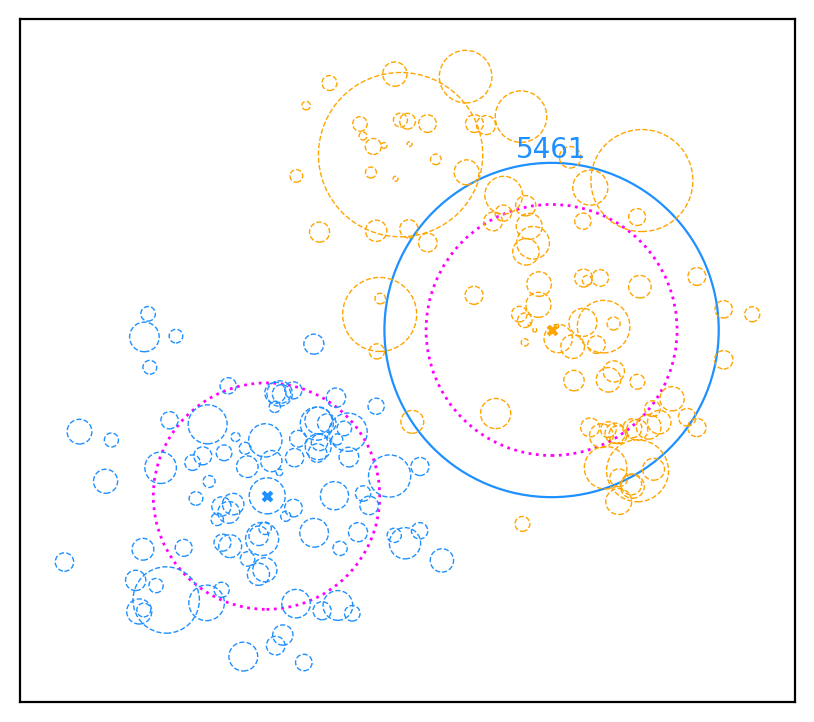

In [5]:
groups = [7,10]
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [6]:
LG[7]['subs'] = LG[7]['subs'][LG[7]['subs']['id'] != 5461]
LG[7]['real'] = LG[7]['real'][LG[7]['real']['hid'] != 5461]

[11] H:24588 (dodgerblue)
[25] H:5476 (orange)


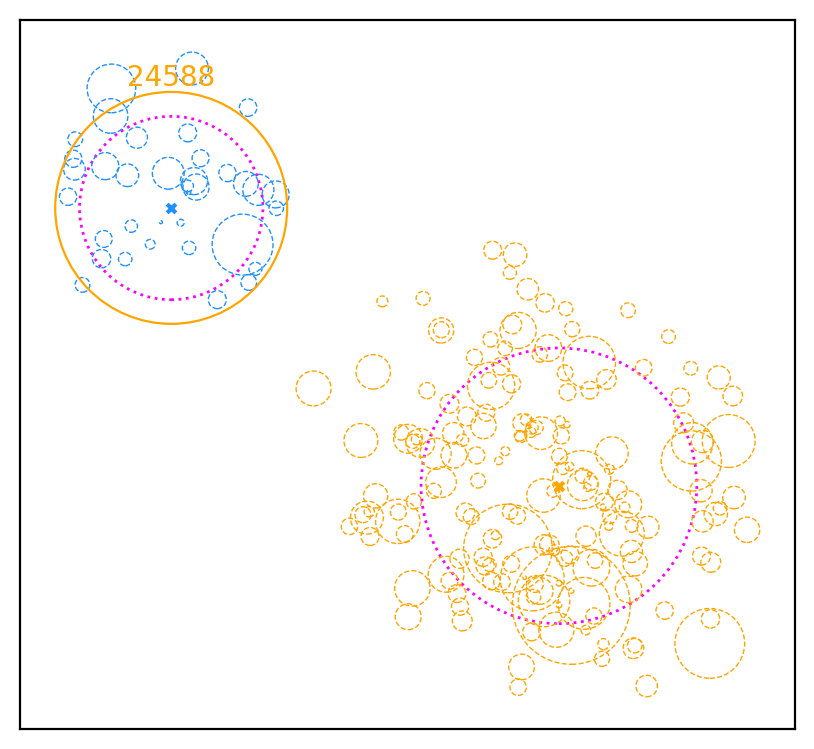

In [7]:
groups = [11,25]
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [8]:
key = 25
remove = 24588
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]

[9] H:3321 (dodgerblue)
[29] H:23150 (orange)


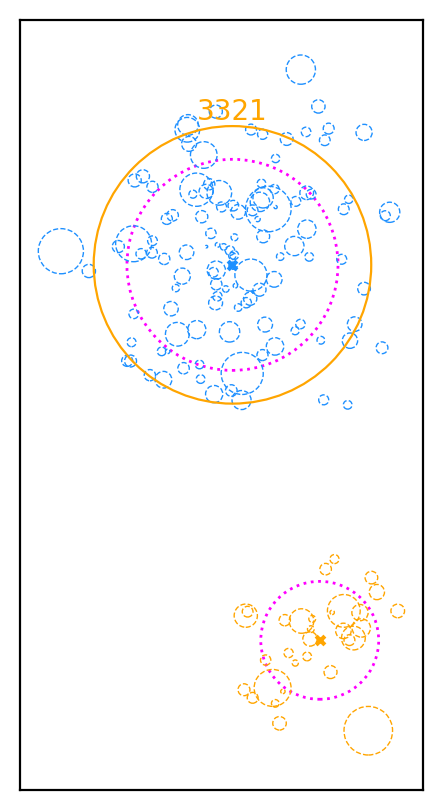

In [9]:
groups = [9, 29]
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [10]:
key = 29
remove = 3321
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]

[2] H:1417 (dodgerblue)
[4] H:573 (orange)
[35] H:9398 (limegreen)
[52] H:4068 (red)
[92] H:19515 (slateblue)
[2] H:1417 (dodgerblue)
[4] H:573 (orange)
[35] H:9398 (limegreen)
[52] H:4068 (red)
[92] H:19515 (slateblue)


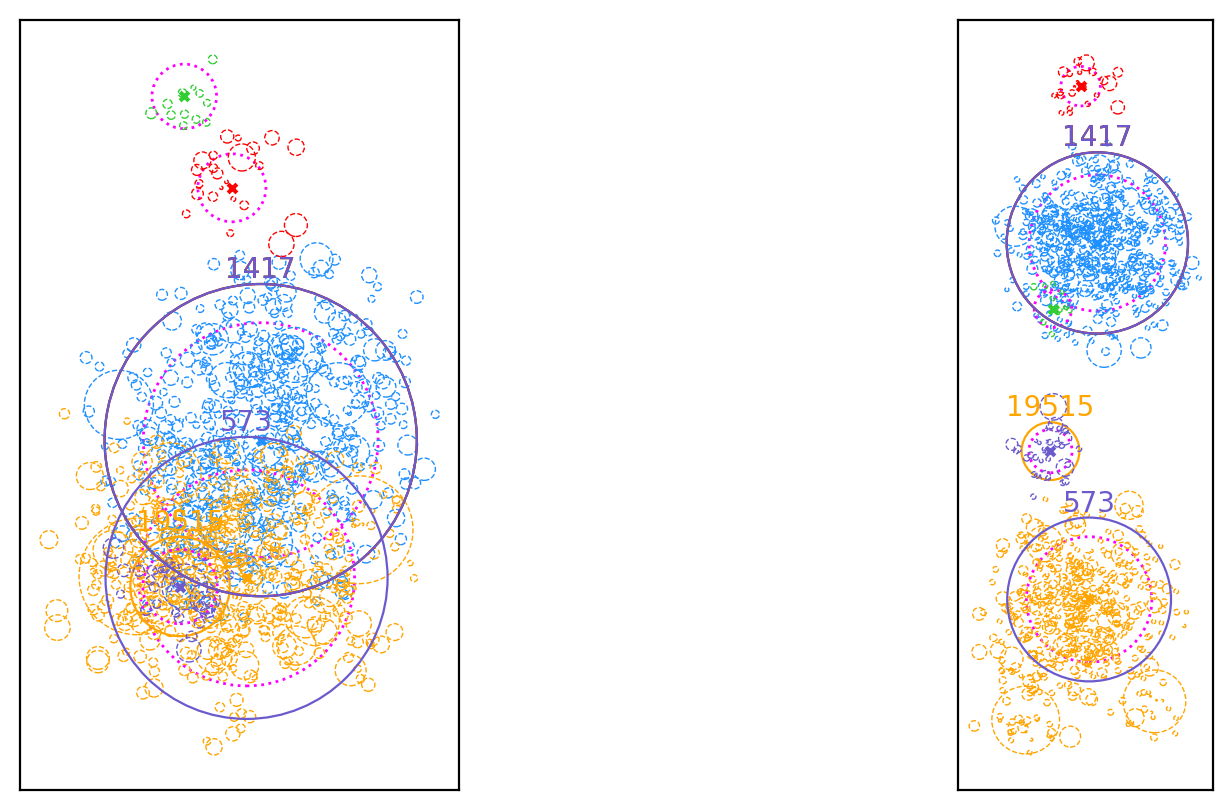

In [11]:
groups = [2, 4, 35, 52, 92]
fig, axes = plt.subplots(1,2,figsize=(10,5), dpi=200)
ax = axes[0]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)
ax = axes[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['z'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['z']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['z']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['z']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['z']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [12]:
# Galaxy[4] <-> Galaxy[92]
# 	! 19515 Found !
# Galaxy[4] <-> Galaxy[92]
# 	! 573 Found !
# Galaxy[92] <-> Galaxy[4]
# 	! 573 Found !
# Galaxy[92] <-> Galaxy[4]
# 	! 19515 Found !

In [13]:
key = 4
remove = 19515
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]
key = 35
remove = 1417
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]
key = 52
remove = 1417
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]
key = 92
remove = 1417
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]
key = 92
remove = 573
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]

[40] H:1340 (dodgerblue)
[108] H:1356 (orange)


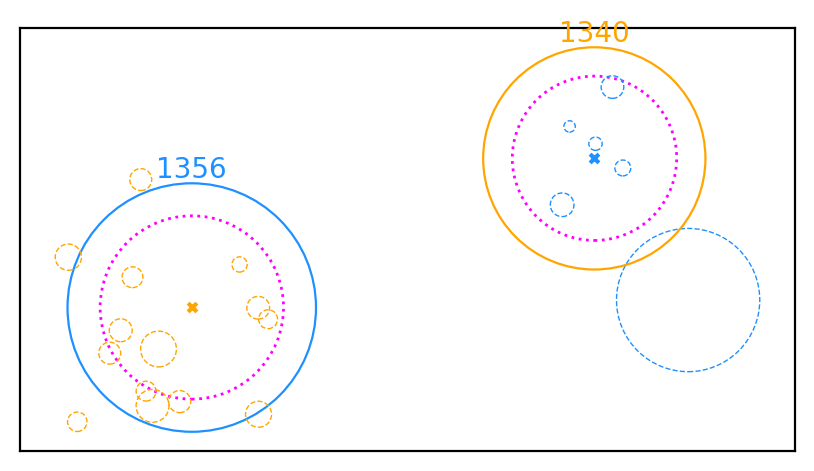

In [14]:
groups = [40, 108]
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [15]:
key = 40
remove = 1356
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]
key = 108
remove = 1340
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]

[36] H:5540 (dodgerblue)
[84] H:6368 (orange)


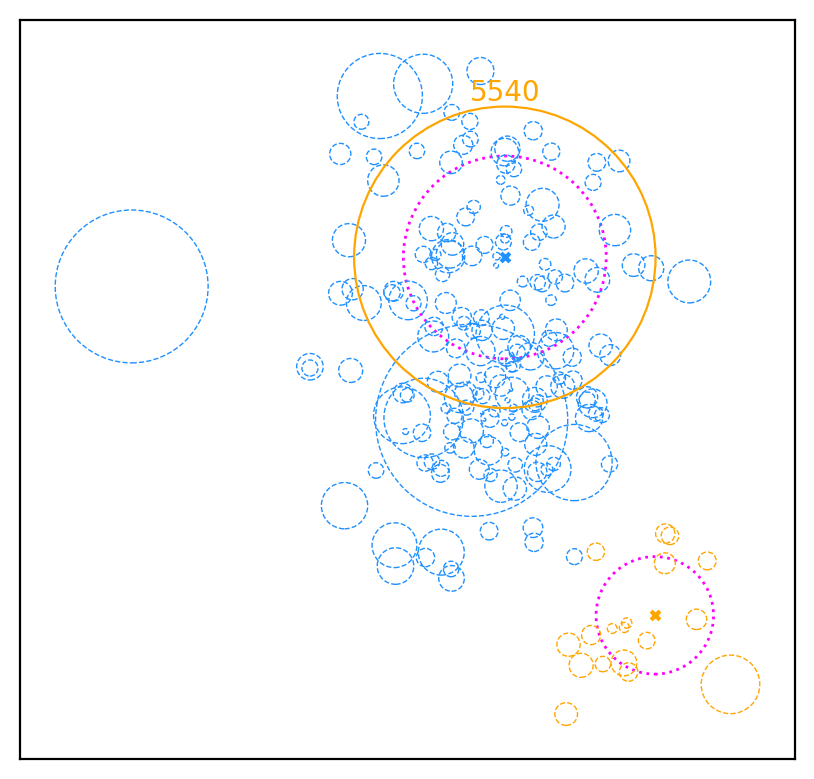

In [16]:
groups = [36, 84]
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
init_colors()

subids = None
for key in groups:
    subs = LG[key]['subs']
    subids = subs['id'] if(subids is None) else np.hstack((subids, subs['id']))
    subids = np.append(subids, LG[key]['BGG']['halo_id'])
unique, count = np.unique(subids, return_counts=True)
unis = unique[count>1]
for key in groups:
    color = get_color()
    BGG = LG[key]['BGG']
    print(f"[{key}] H:{BGG['halo_id']} ({color})")
    subs = LG[key]['subs']

    ax.scatter(BGG['x'], BGG['y'], s=10, color=color, marker='x')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='magenta', fill=False, ls=':')
    ax.add_patch(cir)

    for sub in subs:
        if(sub['id'] in unis):
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.8, ls='-')
            ax.text(sub['x'], sub['y']+sub['rvir'], sub['id'], fontsize=10, color=color,ha='center',va='bottom')
        else:
            cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=color, fill=False, lw=0.5, ls='--')
        ax.add_patch(cir)
ax.set_aspect(1)

In [17]:
key = 84
remove = 5540
LG[key]['subs'] = LG[key]['subs'][LG[key]['subs']['id'] != remove]
LG[key]['real'] = LG[key]['real'][LG[key]['real']['hid'] != remove]

In [18]:
pklsave(LG, "./database/00_LocalGroup_fix.pickle")

In [19]:
BGGs = None
for key in LG.keys():
    BGG = LG[key]['BGG']
    BGGs = BGG if(BGGs is None) else np.hstack((BGGs, BGG))
assert len(BGGs) == len(np.unique(BGGs['halo_id']))

subs = None
hosts = None
allsubs = {}
for key in LG.keys():
    sub = LG[key]['subs']
    host = np.full(len(sub), key, dtype=int)
    subs = sub if(subs is None) else np.hstack((subs, sub))
    hosts = host if(hosts is None) else np.hstack((hosts, host))
    allsubs[key] = np.append( LG[key]['subs']['id'], LG[key]['BGG']['halo_id'] )


for key in LG.keys():
    mysubs = allsubs[key]
    for jkey in LG.keys():
        if(key == jkey): continue
        jsubs = allsubs[jkey]
        for mysub in mysubs:
            if(mysub in jsubs):
                print(f"Galaxy[{key}] <-> Galaxy[{jkey}]")
                print(f"\t! {mysub} Found !")
                raise ValueError(f"Galaxy[{key}] <-> Galaxy[{jkey}]")